# Aquila

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/Gouldbelt/Aquila/'
name = 'aquilaM2'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [2]:
figfile = path + 'HGBS_' + name + '_column_density_map.fits'

In [3]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

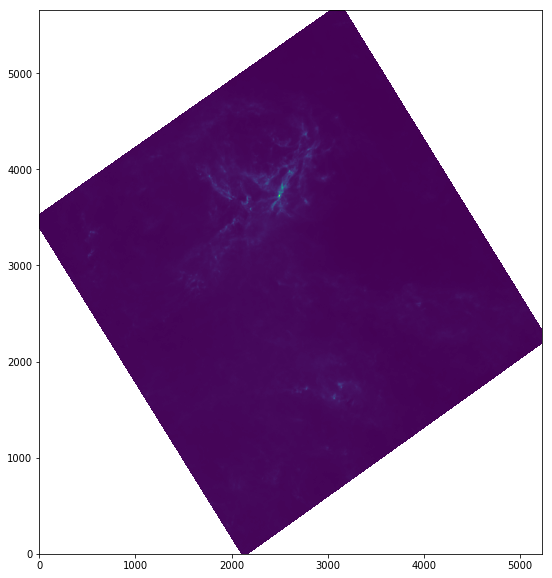

In [4]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

INFO: Auto-setting vmin to  1.442e+20 [aplpy.core]
INFO: Auto-setting vmax to  2.609e+22 [aplpy.core]


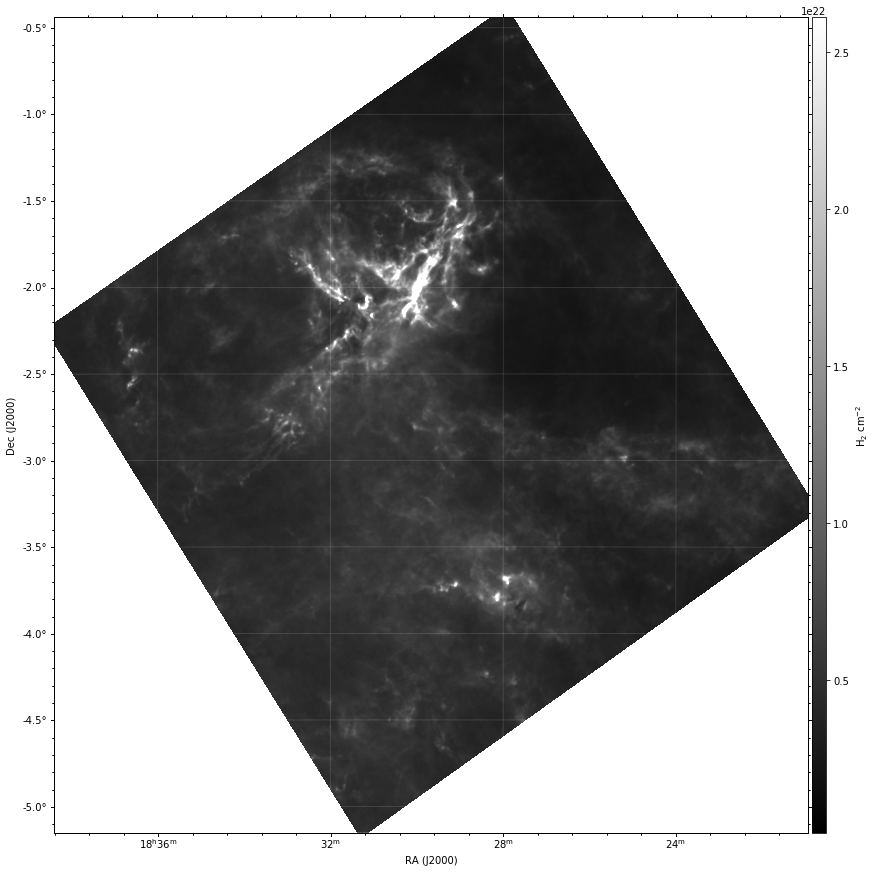

In [5]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [6]:
header

SIMPLE  =                    T / Written by IDL:  Mon Jul 27 12:24:31 2015      
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 5233 / length of data axis 1                          
NAXIS2  =                 5657 / length of data axis 2                          
COMMENT   Science data image                                                    
CREATOR = 'IDL     '           / FITS file creator                              
TELESCOP= 'Herschel Space Observatory' / Name of telescope                      
INSTRUME= 'SPIRE/PACS'         / Herschel instrument                            
PROPOSAL= 'KPGT_pandre_1'      / Herschel proposal ID                           
PRTITLE = 'Herschel Gould Belt Survey (HGBS)' / Program Title                   
COMMENT   Reference publication of the survey: Andre' et al. (2010)             
COMMENT   bibcode: 2010A&A..

In [5]:
import reproject as proj

In [8]:
hdproj = header.copy()

ratio = 0.00388889/0.00083333333333333

#Change pixel resolution
hdproj['CDELT1'] = -0.00388889
hdproj['CDELT2'] = 0.00388889
hdproj['CRPIX1'] = header['CRPIX1']/ratio
hdproj['CRPIX2'] = header['CRPIX2']/ratio
hdproj['NAXIS1'] = np.int(header['NAXIS1']/ratio)
hdproj['NAXIS2'] = np.int(header['NAXIS2']/ratio)
#Rotate the map
hdproj['CROTA1'] = 58.1053
hdproj['CROTA2'] = 58.1053


improj = proj.reproject_exact(HDU,hdproj)
improjnp = np.asarray(improj)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits',improjnp[0,:,:], hdproj, overwrite=True)

In [6]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

INFO: Auto-setting vmin to  3.976e+20 [aplpy.core]
INFO: Auto-setting vmax to  2.313e+22 [aplpy.core]


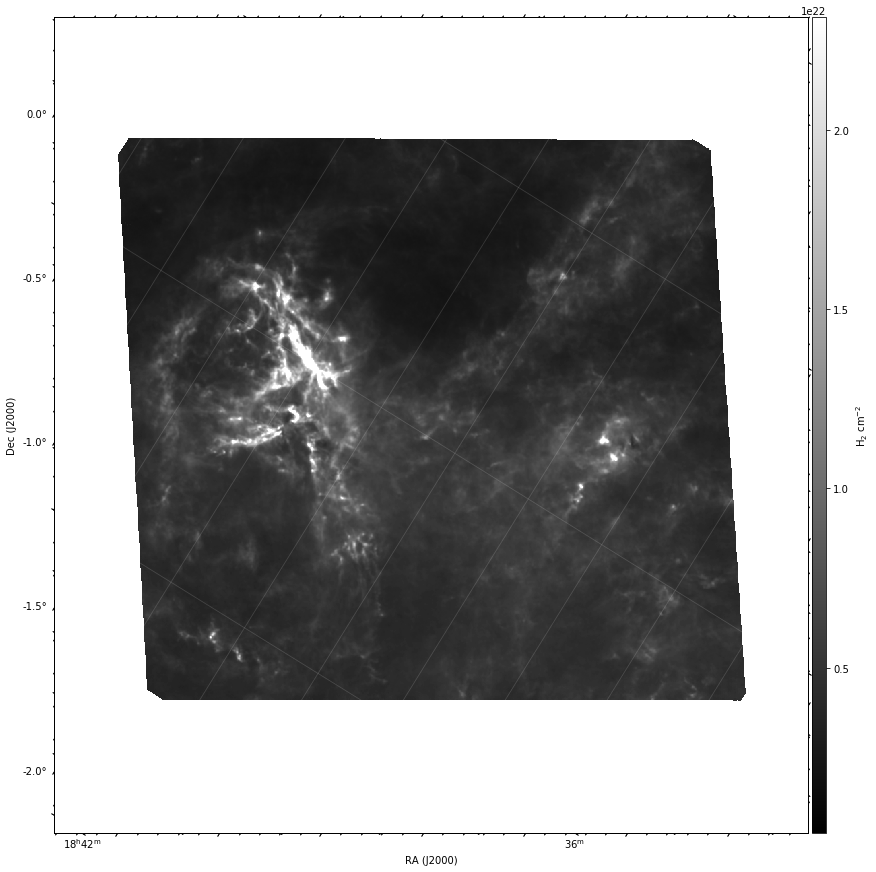

In [10]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [7]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits')
im = HDU[0].data
header = HDU[0].header

In [8]:
#Cut the map
input = path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits'
output = path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits'
coords = np.array([149,232,870,956])
#coords = np.array([171,439,470,897])
subfits(input,output,coords)

Dimensions 722 725


In [9]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to -4.138e+19 [aplpy.core]
INFO: Auto-setting vmax to  2.818e+22 [aplpy.core]


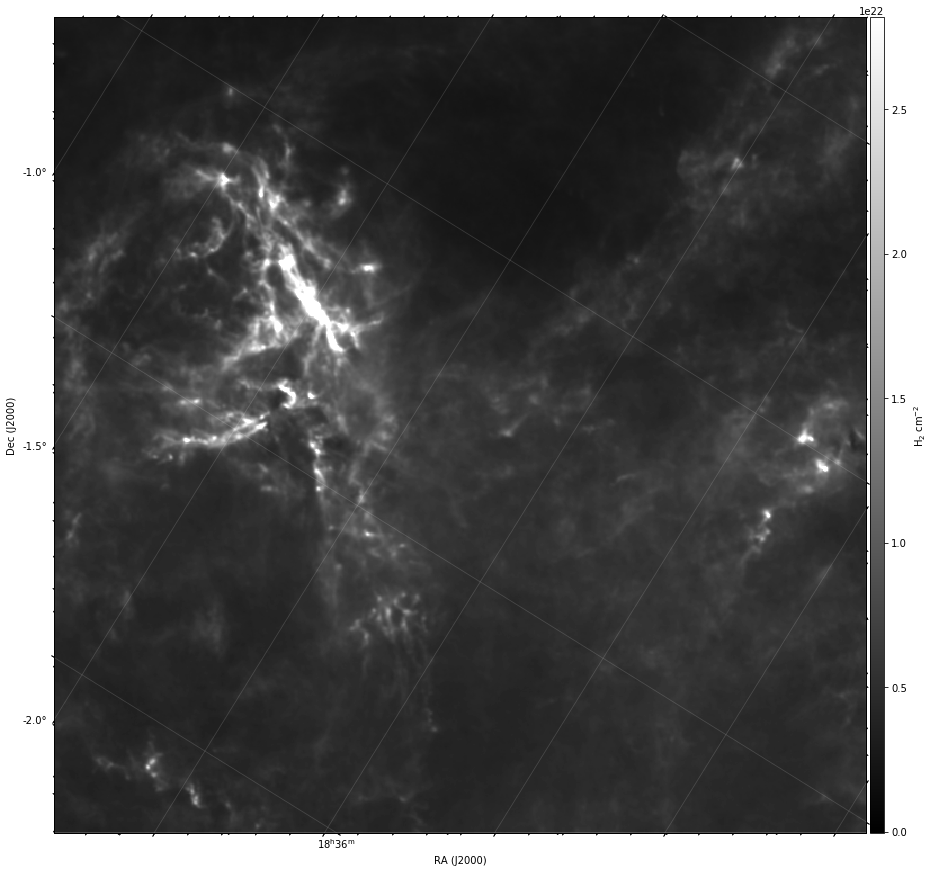

In [10]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [11]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((800,800))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

In [12]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

800 800


Text(0.5, 1.0, 'Beam power spectrum')

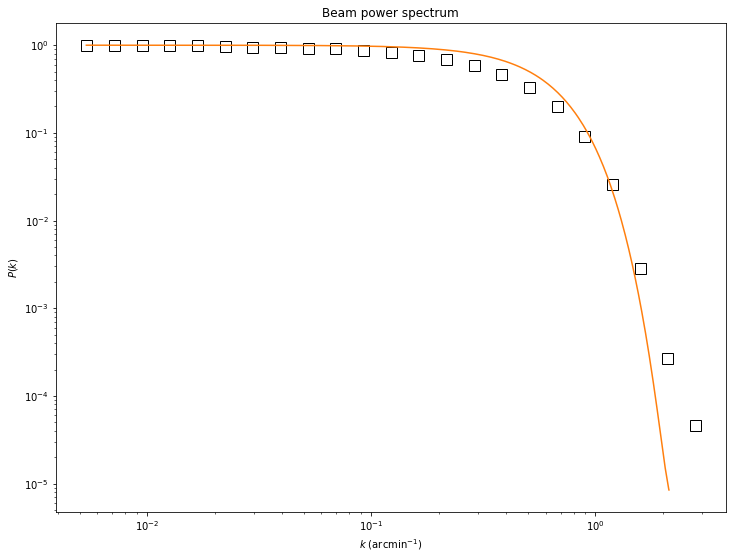

In [13]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[0],newdim[1],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Power law fit
Coherent wavelet
A, Gamma, P0 =  4.02638e+42 -2.04094 1.11094e+41
Gaussian wavelet
A, Gamma, P0 =  6.51416e+39 -3.30904 1.52377e+40


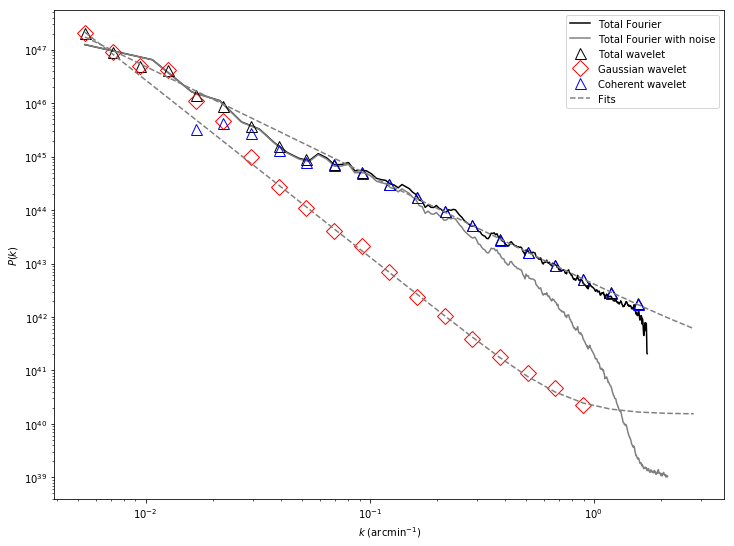

In [14]:
Noise = np.mean(spec_k[(tab_k>1.7) & (tab_k<2.)])

#Power spectra fits
A_gauss, gamma_gauss, P0_gauss = 0.0651416e+41, -3.30904, 0.152377e+41
fit_gauss=A_gauss*wav_k**gamma_gauss+P0_gauss
A_cohe, gamma_cohe, P0_cohe = 40.2638e+41, -2.04094, 1.11094e+41
fit_cohe=A_cohe*wav_k**gamma_cohe+P0_cohe

print('Power law fit')
print('Coherent wavelet')
print('A, Gamma, P0 = ', A_cohe, gamma_cohe, P0_cohe)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', A_gauss, gamma_gauss, P0_gauss)


plt.figure(figsize(12,9))
plt.plot(tab_k[:-75], (spec_k[:-75]-Noise)/spec_beamn2[:-75], color='black',label=r'Total Fourier')
plt.plot(tab_k, spec_k, color='grey',label=r'Total Fourier with noise')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')

plt.plot(wav_k, fit_gauss, color='grey', ls='--', lw=1.5, label=r'Fits')
plt.plot(wav_k, fit_cohe, color='grey', ls='--', lw=1.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

plt.savefig(path + 'HGBS_' + name + '_column_density_map_power_spec.png', dpi=500)

In [15]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M,:,:].real,axis=0)
scale_free = np.sum(wt[2*M:3*M,:,:].real,axis=0)

fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits', filaments, header, overwrite=True)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits', scale_free, header, overwrite=True)

INFO: Auto-setting vmin to -6.986e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.829e+22 [aplpy.core]
INFO: Auto-setting vmin to -4.359e+21 [aplpy.core]
INFO: Auto-setting vmax to  8.419e+21 [aplpy.core]


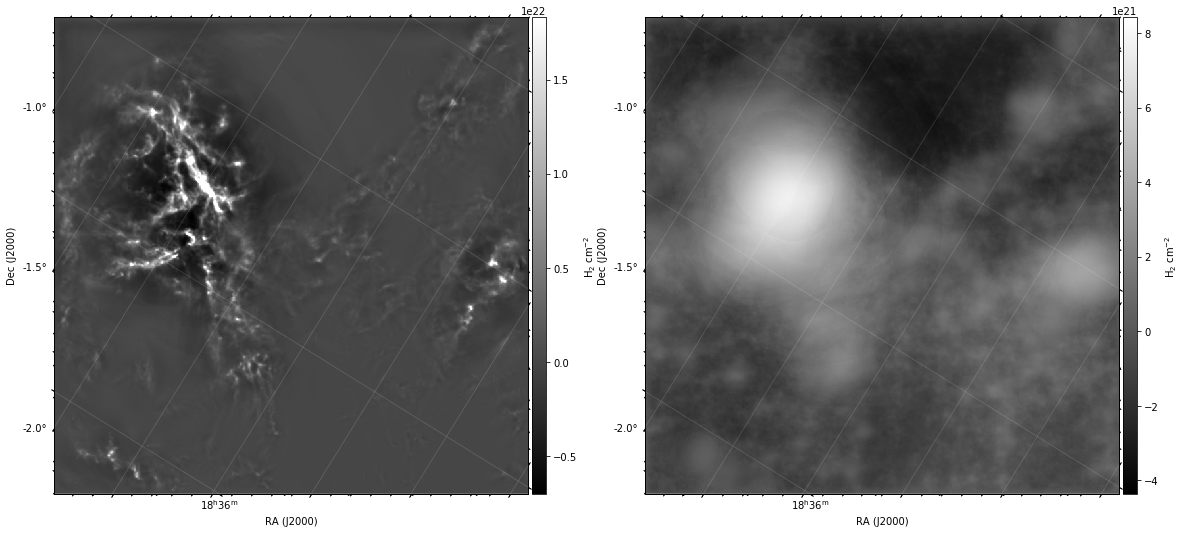

In [16]:
fig_all = plt.figure(1, figsize=(30,30))

fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits',figure=fig_all, subplot=(1,3,1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits',figure=fig_all, subplot=(1,3,2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')